# Working with Tensorforce to train a reinforcement-learning agent

This notebook serves as an educational introduction to the usage of Tensorforce using a gym-electric-motor (GEM) environment. The goal of this notebook is to give an understanding of what tensorforce is and how to use it to train and evaluate a reinforcement learning agent that can solve a current control problem of the GEM toolbox.

The following code snippets are only needed if you are executing this file directly from a cloned GitHub repository where you don't have GEM installed

In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent.parent))

## 1. What you need

Before you can start you need to make sure that you have both gym-electric-motor and tensorforce installed. You can install both easily using pip:

  - ```pip install gym-electric-motor```
  - ```pip install tensorforce```

Alternatively, you can install their latest developer version directly from GitHub:

  - [GitHub Gym-Electric-Motor](https://github.com/upb-lea/gym-electric-motor)
  - [GitHub Tensorforce](https://github.com/tensorforce/tensorforce)

You also need to make sure that numpy and gym are installed. You can install both using pip, too. After you have done that you should be able to execute the following cells without any problems.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2 Setting up the GEM-Environment

The basic idea behind reinforcement learning is to create a so-called agent, that should learn by itself to solve a specified task in a given environment. This environment gives the agent feedback on its actions an reinforces the targeted behavior.
In this notebook, we focus on the task to train a controller for the current control of a *Permanent Magnet Synchronous Motor* (*PMSM*).
 
In the following, we briefly present the used GEM-envrionment, but this notebook does not focus directly on the detailed usage of GEM. If you are new to the used environment and interested in finding out what it does and how to use it, we recommend taking a look at the educational notebook which is dealing with GEM.

To save some space in this notebook, we will use a function defined in an external python file called **getting_environment.py**. If you want to know how we defined our environment's parameters you can take a look at that file. By simply calling the **get_env()** function from the external file, you can set up our used environment for a *PMSM* with discrete inputs.

The basic idea of the control-setup from the GEM-environment is displayed in the following figure. 

![Motor Setup](img/SCML_Setting.svg)

The agent controls the converter who converts the supply currents to the currents flowing into the motor - for the *PMSM*: $i_{sq}$ and $i_{sd}$

In the continuous case, the agent's action is controlling the converter's output voltage directly through means of duty cycling. In the discrete case, the agent's action decides which converter switches are open and which are closed. Therefore, only a discrete amount of options are available. For this environment, we are using the *Discrete B6 Bridge Converter* which has three six which leads to a total of eight possible actions the agent can take.

![Motor Setup](img/B6.svg)

The motor is described through the schematic:

![Motor Setup](img/ESBdq1.svg)

Which leads to the electrical ODEs:

<h3 align="center">

$ \frac{\mathrm{d}i_{sd}}{\mathrm{d}t}=\frac{u_{sd} + p\omega_{me}L_q i_{sq} - R_s i_{sd}}{L_d} $ <br><br>
$\frac{\mathrm{d} i_{sq}}{\mathrm{d} t}=\frac{u_{sq} - p \omega_{me} (L_d i_{sd} + \mathit{\Psi}_p) - R_s i_{sq}}{L_q}$ <br><br>
$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>
The target for the agent is now to learn to control the currents. For this, a reference generator generates a trajectory that the agent has to follow. Therefore, he has to learn to solve the ODEs and convert voltages accordingly. 

For a deeper understanding of the used models behind the environment the documentation can be found [here](https://upb-lea.github.io/gym-electric-motor/).

The following code is using our pre-written function get_env to import our pre-defined GEM environment.

In [3]:
from getting_environment import get_env
# creating the described environment
env = get_env(training=True)

/home/pascal/anaconda3/envs/tf_5_env/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 3. Using Tensorforce

To take advantage of some already implemented deep-RL agents, we use the *tensorforce-framework*. It is built on *TensorFlow* and offers agents based on deep Q-networks, policy gradients, or actor-critic algorithms. 

For more information to specific agents or different modules that can be used, some good explanations can be found in the corresponding [documentation](https://tensorforce.readthedocs.io/en/latest/).
   
For the control task with a discrete action-space we will use a *deep-Q-network* (DQN). The necessary knowledge about DQN's can be acquired in the original article [here](https://www.nature.com/articles/nature14236) or for a deeper look into the basics of reinforcement learning in the book "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto

### 3.1 Defining an Tensorforce-Environment

For using tensorforce, you need to define a *tensorforce-environment*. This is done simply by using the **Environment.create** interface. This takes your normal gym-like environment with some additional arguments. Gym-like means in this context an environment, which is built after the example from the gym-environments from [Open-AI](https://github.com/openai/gym).

In [4]:
from tensorforce.environments import Environment
# maximal timesteps per episode for training 
max_episode_steps = 10000
# creating tensorforce environment
tf_env = Environment.create(environment=env,
                            max_episode_timesteps=max_episode_steps)

### 3.2 Setting-up an Tensorforce-Agent

The Agent is created just like the environment. The agent's parameters can be passed as arguments from the create function or via a configuration as a dictionary or as *.json* file.
In the following, the way via a dictionary is used.

With the *tensorforce-framework* it is possible to define own network-architectures like it is shown in the code snippet. For some parameters, it can be useful to haven a decaying value during the training. A possible way for this is also shown in the following code.

The exact meaning of the used parameters can be found in the already mentioned tensorforce documentation.


In [5]:
# using a parameter decay for the exploration
epsilon_decay = {'type': 'decaying',
                 'decay': 'polynomial',
                 'decay_steps': 50000,
                 'unit': 'timesteps',
                 'initial_value': 1.0,
                 'decay_rate': 5e-2,
                 'final_value': 5e-2,
                 'power': 3.0}

# defining a simple network architecture: 2 dense-layers with 64 nodes each
net = [
    dict(type='dense', size=64, activation='relu'),
    dict(type='dense', size=64, activation='relu'),
]

# defining the parameters of an dqn-agent
agent_config = {
    'agent': 'dqn',
    'memory': 200000,
    'batch_size': 25,
    'network': net,
    'update_frequency': 1,
    'start_updating': 10000,
    'learning_rate': 1e-4,
    'discount': 0.99,
    'exploration': epsilon_decay,
    'target_sync_frequency': 1000,
    'target_update_weight': 1.0,
    }

In [6]:
from tensorforce.agents import Agent

tau = 1e-5
simulation_time = 5 # seconds
training_steps = int(simulation_time // tau)
# creating agent via dictionary
dqn_agent = Agent.create(agent=agent_config, environment=tf_env)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### 3.3 Training the agent

Training the agent is executed with the **tensorforce-runner**. The runner stores metrics during the training, like the reward per episode, and can be used to save learned agents. If you just want to experiment a little with an already trained agent, it is possible to skip the next cells and just load a pre-trained agent.

In [7]:
from tensorforce.execution import Runner

# create and train the agent
runner = Runner(agent=dqn_agent, environment=tf_env)
runner.run(num_timesteps=training_steps)

Timesteps: 100%|█████████▉| 499130/499999 [31:54<00:03, 250.55it/s, mean_reward=n/a]

With accessing saved metrics from the runner, it for example possible to have a look on the mean-reward per episode or the corresponding episode-length. It is possible to load an array with the mean rewards per episode, so you don't have to run the whole training.

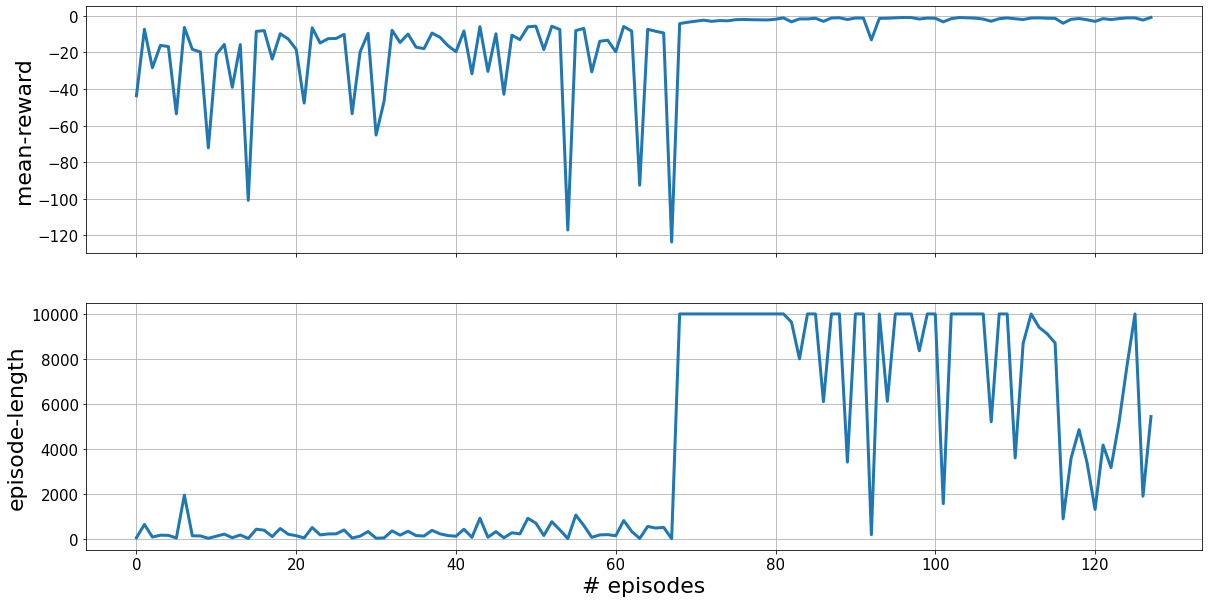

number of episodes during training:  128


In [8]:
# uncomment to load the array
rewards = np.load('saved_agents/rewards_per_episode.npy')
episode_length = np.load('saved_agents/length_per_episode.npy')

# comment, if the array is loaded above
# accesing the metrics from runner
#rewards = np.asarray(runner.episode_rewards)
#episode_length = np.asarray(runner.episode_timesteps)

# calculating the mean-reward per episode
mean_reward = rewards/episode_length
num_episodes = len(mean_reward)

# plotting mean-reward over episodes
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))
ax1.plot(range(num_episodes), mean_reward, linewidth=3)
#plt.xticks(fontsize=15)
ax1.set_ylabel('mean-reward', fontsize=22)
ax1.grid(True)
ax1.tick_params(axis="y", labelsize=15) 
# plotting episode length over episodes
ax2.plot(range(num_episodes), episode_length, linewidth=3)
ax2.set_xlabel('# episodes', fontsize=22)
ax2.set_ylabel('episode-length', fontsize=22)
ax2.tick_params(axis="y", labelsize=15) 
ax2.tick_params(axis="x", labelsize=15) 

ax2.grid(True)

plt.show()

print('number of episodes during training: ', len(rewards))

Saving the agents trained model, makes it avaible for a seperate evalutation and further usage.

In [9]:
# uncomment the code and execute cell to save the trained agent
# agent_path = 'saved_agents'
# agent_name = 'dqn_agent_tensorforce'
# runner.agent.save(directory=agent_path, filename=agent_name)
# print('\n agent saved \n')
# runner.close()

## 4. Evaluating the trained agent

### 4.1 Loading a model

If a previously saved agent is available, it can be restored by using the runner to load the model with the **.load()** function. To load the agent it is necessary to pass the directory, the filename, the environment, and the agent configuration used for the training.

In [10]:
from tensorforce import Agent

agent_path = 'saved_agents'
agent_name = 'dqn_agent_tensorforce'

dqn_agent = Agent.load(
    directory=agent_path,
    filename=agent_name,
    environment=tf_env,
    **agent_config
)
print('\n agent loaded \n')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Restoring parameters from saved_agents/dqn_agent_tensorforce

 agent loaded 



### 4.3 Evaluating the agent


To use the trained agent as a controller, a typical loop to interact with the environment can be used, which is displayed in the cell below. Here it is necessary to define a new test-environment with the **get_env()** function, which disables the episode-time-limit for the agent.

Now the agent takes the observations from the environment and reacts with an action, which is used to control the environment. To get an impression of how the trained agent performs, the trajectory of the control-states can be observed. A live-plot will be displayed in a jupyter-notebook. If you are using jupyter-lab, the following cell could cause problems regarding the visualization.

/home/pascal/anaconda3/envs/tf_5_env/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


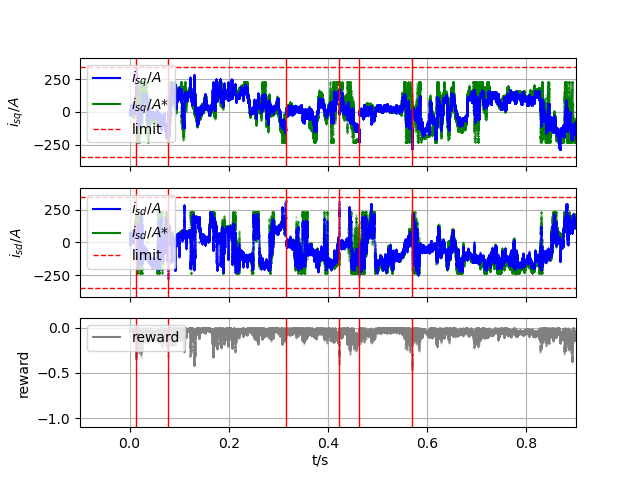

Timesteps: 100%|█████████▉| 499130/499999 [32:10<00:03, 250.55it/s, mean_reward=n/a]

In [11]:
%matplotlib notebook
env = get_env(time_limit = False, training=False)
# currently the visualization crashes for larger values, than the defined value
visualization_steps = int(9e4) 
obs = env.reset()
for step in range(visualization_steps):
    # getting the next action from the agent
    actions = dqn_agent.act(obs, evaluation=True)
    # the env return the next state, reward and the information, if the state is terminal
    obs, reward, done, _ = env.step(action=actions)
    # activating the visualization
    env.render()

    if done:
        # reseting the env, if a terminal state is reached
        obs = env.reset()


In the next example a classic *environment-interaction loop* can be extended to access different metrics and values, e.g. the cumulated reward over all steps. The number of evaluation-steps can be reduced, but a higher variance of the evaluation result must than be accepted.

In [12]:
# test agent
env = get_env(time_limit = False, training=False)

steps = 250000#int(1e5)

rewards = []
episode_lens = []

obs = env.reset()
terminal = False
cumulated_rew = 0
step_counter = 0
episode_rew = 0

for step in (range(steps)):
    actions = dqn_agent.act(obs, evaluation=True)
    obs, reward, done, _ = env.step(action=actions)
    
    cumulated_rew += reward
    episode_rew += reward
    
    step_counter += 1

    if done:
        rewards.append(episode_rew)
        episode_lens.append(step_counter)
        episode_rew = 0
        step_counter = 0
        
        obs = env.reset()
        done = False

print(f' \n Cumulated reward per step is {cumulated_rew/steps} \n')
print(f' \n Number of episodes Reward {len(episode_lens)} \n')




/home/pascal/anaconda3/envs/tf_5_env/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


 
 Cumulated reward per step is -0.06620856852414016 

 
 Number of episodes Reward 17 



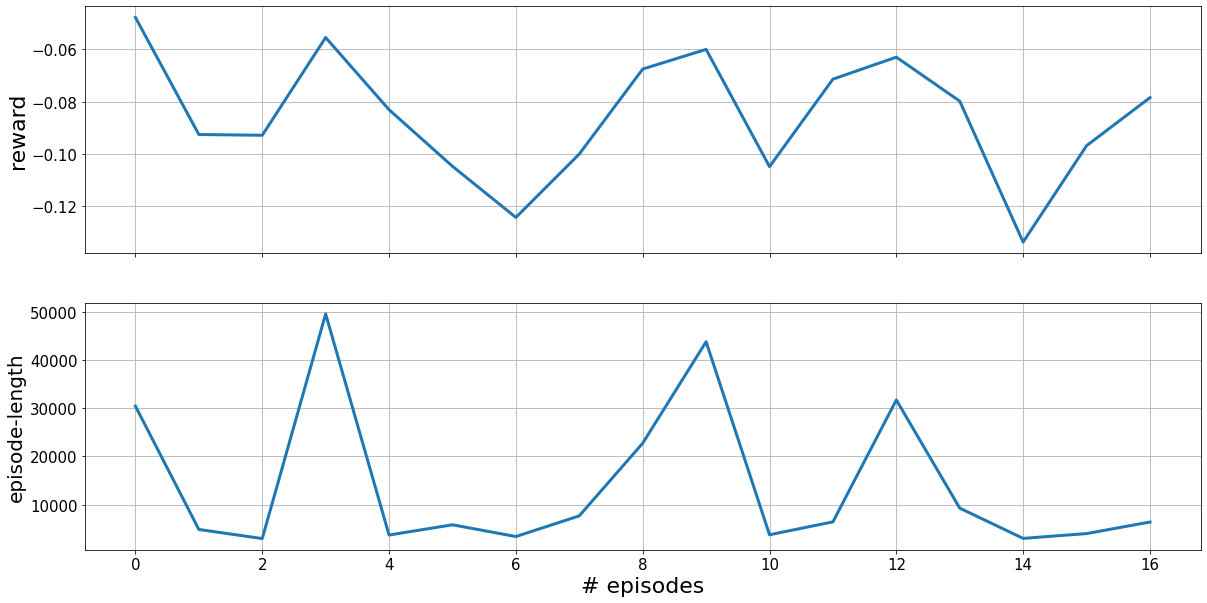

number of episodes during training:  17


In [13]:
%matplotlib inline
# accesing the metrics from runner
rewards = np.asarray(rewards)
episode_length = np.asarray(episode_lens)
# calculating the mean-reward per episode
mean_reward = rewards/episode_length
num_episodes = len(rewards)

# plotting mean-reward over episodes
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
ax1.plot(range(num_episodes), mean_reward, linewidth=3)
#plt.xticks(fontsize=15)
ax1.set_ylabel('reward', fontsize=22)
ax1.grid(True)
ax1.tick_params(axis="y", labelsize=15) 
# plotting episode length over episodes
ax2.plot(range(num_episodes), episode_length, linewidth=3)
ax2.set_xlabel('# episodes', fontsize=22)
ax2.set_ylabel('episode-length', fontsize=20)
ax2.tick_params(axis="y", labelsize=15) 
ax2.tick_params(axis="x", labelsize=15) 

ax2.grid(True)

plt.show()

print('number of episodes during training: ', len(episode_lens))